# Analyzing Reboots and Remakes
This notebook outlines my process for analyzing the sucess of reboots and remakes of movies that were scraped from Boxofficemojo.com using the script provided.  Some things to keep in mind:

- The dataset we are working with is pretty small, only about 70 movies, this is due to the fact that many of the older movies that have been remade do not have a lot of the data we need.

- We define success to be Domestic Total Gross and its our target variable for all of our regression models.  Return on Investment is possibly a better metric for success but due to the lack of reliable budget information for older movies I decided to use Domestic Total Gross.

- It should also be noted that all of the Domestic Total Gross values I am looking at are adjusted for ticket price inflation but not for general inflation.

- We will be using p-value < 0.05 as our threshold for determining statistical significance.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
rng = np.random.RandomState(42)

## Load the Data
We have all of the movie data that we scraped and we're loading it into a dataframe but we want to discard entries that don't have a budget value since we don't want missing data.

In [3]:
movies_df = pd.read_pickle('movie-data.pkl')
movies_df = movies_df[movies_df['budget'] > 0]

## Data Exploration and Initial Analysis
Now that we have our data in a usable format, we can take a look at our data and see what is going on and if we can gain some initial insights into where we should go with our analysis.  I decided to look at our three non-binary variables as we are going to use Linear Regression as our model and numerical data tends to work better with that.

In the first graph we are looking at the comparison between the Domestic Total Gross (DTG) of the original movies and their reboot/remake counterpart.  As you can see there really isn't an obvious relationship between these two variables, in fact the data looks pretty heteroskedastic which presents issues with the assuptions for linear regression, we will attempt to address this later.

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


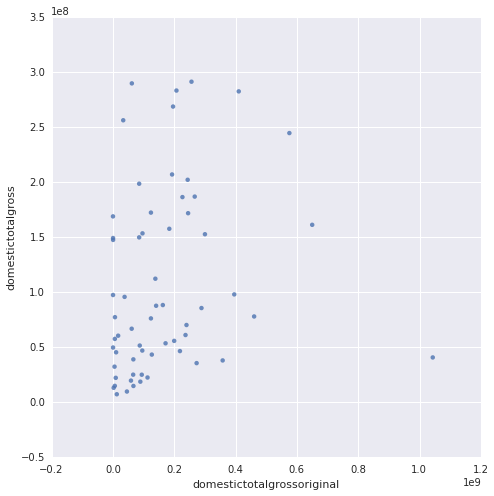

In [4]:
%matplotlib inline

sns.lmplot("domestictotalgrossoriginal", "domestictotalgross", data=movies_df, fit_reg = False, size=7)

A quick regression plot confirms to us that there isn't a really good relationship between the variables, the confidence interval is pretty wide, particularly near the areas where there are some points that look like outliers.

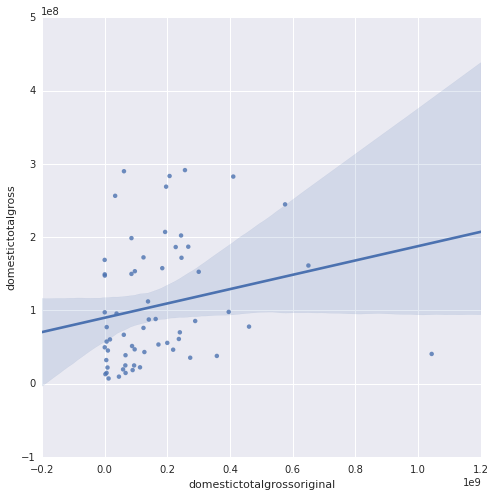

In [5]:
sns.lmplot("domestictotalgrossoriginal", "domestictotalgross", data=movies_df, size=7)

Next we'll take a look at the relationship between the time difference of our movie pairs versus our target variable.  The time difference variable is just the number of days between releases of the original movie and the remake/reboot movie.  I wanted to see if there was perhaps some sort of nostalgia effect and movies released on a certain window end up being more sucessful.  Unfortunately we have the same issue with heteroskedacity as previously and there doesn't seem to be be any real pattern as can be shown in the regression plot below.

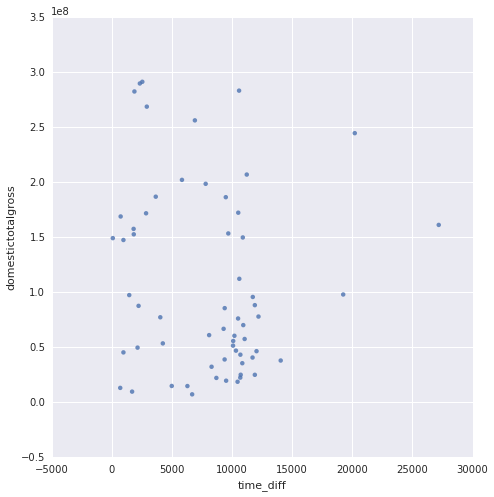

In [6]:
sns.lmplot("time_diff", "domestictotalgross", data=movies_df, fit_reg = False, size=7)

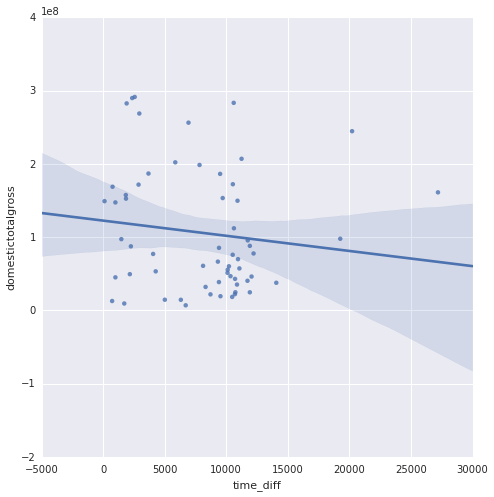

In [7]:
sns.lmplot("time_diff", "domestictotalgross", data=movies_df, size=7)

Finally I looked at budget, specifically the production budget of the remake/reboot.  This is a pretty intuitive relationship as you expect higher budget movies to have higher marketing budgets and wider releases so they generally have larger ticket sales.  As expected we get a reasonable linear relationship between the two.

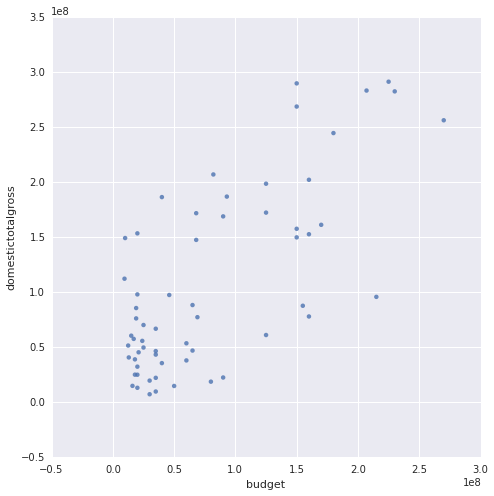

In [8]:
sns.lmplot("budget", "domestictotalgross", data=movies_df, fit_reg=False, size=7)

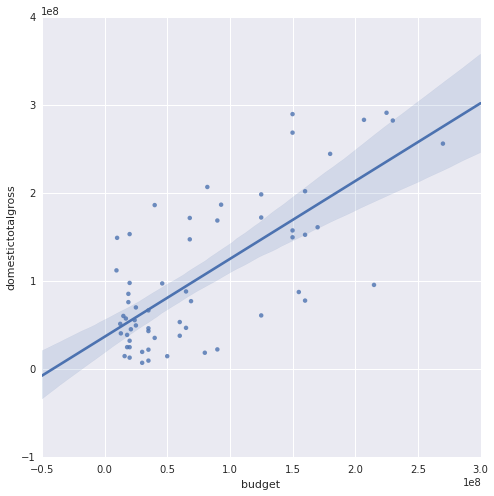

In [9]:
sns.lmplot("budget", "domestictotalgross", data=movies_df, size=7)

# Modeling with Linear Regression
The Seaborn regression plots give us a quick look at our relationships between our variables but we want to take a closer look at what is going on.  We're going to use statsmodels to do OLS with our dataset, this will allow us to look at the residuals as well as the $R^2$ and p values for each of our features. 

In [10]:
y, X = dmatrices('domestictotalgross ~ domestictotalgrossoriginal', data=movies_df, return_type='dataframe')

In [11]:
model1 = sm.OLS(y, X)
results1 = model1.fit()
res = results1.resid
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.861
Date:                Fri, 08 Jan 2016   Prob (F-statistic):             0.0960
Time:                        14:02:53   Log-Likelihood:                -1197.3
No. Observations:                  61   AIC:                             2399.
Df Residuals:                      59   BIC:                             2403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                    8.98e+07   1.42e+07      6.340      0.000      6.15e+07  1.18e+08
domestictotalgrossoriginal     0.0978      0.058      1.691      0.096        -0.018     0.214
==============================================================================
Omnibus:                        5.962   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                6.051
Skew:                           0.748   Prob(JB):                       0.0485
Kurtosis:                       2.625   Cond. No.                     3.29e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see with just the DTG of the original movie we don't have good performance and our one variable isn't quite significant assuming we're accepting p values < 0.05.  To see what's going on a little better we can make a Q-Q plot of our residuals.  Q-Q plots can tell us a bit more about the "goodness of fit" of our model, if our sample quantiles (the residuals) line up on the $45^{\circ}$ line then our model is a perfect fit.

We can see that our model doesn't really follow the straight line pattern that we would expect for a regression model, it almost looks bimodal.  We can try and transform our target variable to the log domain to deal with some of this spread.

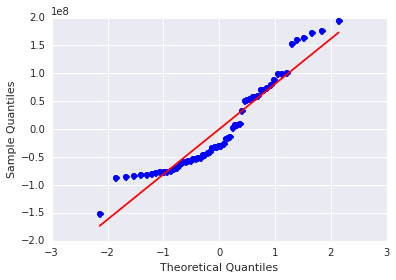

In [12]:
fig = sm.qqplot(res, line='s')
plt.show()

In [13]:
y2, X2 = dmatrices('np.log(domestictotalgross) ~ domestictotalgrossoriginal', data=movies_df, return_type='dataframe')

In [14]:
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
res2 = results2.resid

By applying this transformation we can see that our residuals are much closer to being on the $45^{\circ}$ line.

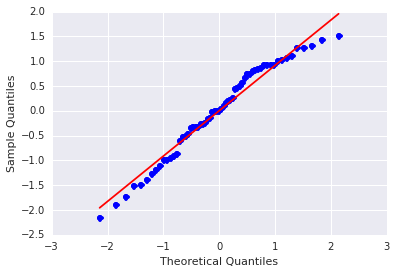

In [15]:
fig2 = sm.qqplot(res2, line='s')
plt.show()

In [16]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(domestictotalgross)   R-squared:                       0.065
Model:                                    OLS   Adj. R-squared:                  0.049
Method:                         Least Squares   F-statistic:                     4.075
Date:                        Fri, 08 Jan 2016   Prob (F-statistic):             0.0481
Time:                                14:03:00   Log-Likelihood:                -81.036
No. Observations:                          61   AIC:                             166.1
Df Residuals:                              59   BIC:                             170.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     17.8868      0.160    111.886      0.000        17.567    18.207
domestictotalgrossoriginal  1.318e-09   6.53e-10      2.019      0.048      1.15e-11  2.62e-09
==============================================================================
Omnibus:                        3.720   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.769
Skew:                          -0.375   Prob(JB):                        0.250
Kurtosis:                       2.273   Cond. No.                     3.29e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And as we can see our variable is now significant at a p-value < 0.05 and we have a better adjusted R-squared statistic, however its still pretty poor so the next step is to add our other variables to see if we can improve our performance with a more complex model. 

In [17]:
y3, X3 = dmatrices('domestictotalgross ~ np.log(domestictotalgrossoriginal) + np.log(time_diff) + budget', data=movies_df, return_type='dataframe')
model3 = sm.OLS(y3, X3)
results3 = model3.fit()

In [18]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     25.05
Date:                Fri, 08 Jan 2016   Prob (F-statistic):           1.82e-10
Time:                        14:03:02   Log-Likelihood:                -1173.1
No. Observations:                  61   AIC:                             2354.
Df Residuals:                      57   BIC:                             2363.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                           1.088e+08   7.18e+07      1.515      0.135     -3.49e+07  2.52e+08
np.log(domestictotalgrossoriginal)  6.771e+06   5.03e+06      1.346      0.184      -3.3e+06  1.68e+07
np.log(time_diff)                  -2.175e+07   9.38e+06     -2.320      0.024     -4.05e+07 -2.98e+06
budget                                 0.8193      0.116      7.086      0.000         0.588     1.051
==============================================================================
Omnibus:                        0.933   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.627   Jarque-Bera (JB):                0.882
Skew:                           0.066   Prob(JB):                        0.643
Kurtosis:                       2.426   Cond. No.                     1.03e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see we have a much better model by adding in the budget and the time difference, however it should be noted that our intercept and DTG no longer have acceptable p values.  Next I wanted to investigated the binary variables which in this case were different genres.  The rational being that maybe a certain genre has better success with reboots/remakes and we can perhaps capitalize on that by looking at only films in that genre when selecting a movie to remake.

In [19]:
y4, X4 = dmatrices('domestictotalgross ~ comedy + action + adventure + horror +'\
                   'romance + music + fantasy + drama + thriller + scifi', data=movies_df, return_type='dataframe')

In [20]:
model4 = sm.OLS(y4, X4)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     3.936
Date:                Fri, 08 Jan 2016   Prob (F-statistic):           0.000746
Time:                        14:03:06   Log-Likelihood:                -1182.7
No. Observations:                  61   AIC:                             2385.
Df Residuals:                      51   BIC:                             2406.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          6.836e+07   2.33e+07      2.933      0.005      2.16e+07  1.15e+08
comedy[T.True]      1.03e+06   1.58e+07      0.065      0.948     -3.06e+07  3.27e+07
action[T.True]     8.499e+06   2.35e+07      0.361      0.720     -3.88e+07  5.58e+07
adventure[T.True]  1.072e+08   2.65e+07      4.045      0.000       5.4e+07   1.6e+08
horror[T.True]    -4.847e+06   3.03e+07     -0.160      0.873     -6.56e+07  5.59e+07
romance[T.True]   -3.141e+07    5.3e+07     -0.593      0.556     -1.38e+08  7.49e+07
music[T.True]     -2.091e+07   4.52e+07     -0.463      0.645     -1.12e+08  6.98e+07
fantasy[T.True]     1.21e+08   4.47e+07      2.709      0.009      3.14e+07  2.11e+08
drama[T.True]      2.603e+07   3.39e+07      0.767      0.446     -4.21e+07  9.41e+07
thriller[T.True]    1.03e+06   1.58e+07      0.065      0.948     -3.06e+07  3.27e+07
scifi[T.True]      5.939e+07   3.29e+07      1.807      0.077      -6.6e+06  1.25e+08
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                0.947
Skew:                          -0.280   Prob(JB):                        0.623
Kurtosis:                       3.242   Cond. No.                     3.78e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.61e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

From this model it seems like only adventure and fantasy are significant genres.  We can then combine this model with our previous model and as we can see we have a better adjusted R-squared statistic.

In [21]:
y5, X5 = dmatrices('domestictotalgross ~ np.log(domestictotalgrossoriginal) + np.log(time_diff) + comedy + action + adventure + horror +'\
                   'romance + music + fantasy + drama + thriller + scifi + budget', data=movies_df, return_type='dataframe')

In [22]:
model5 = sm.OLS(y5, X5)
results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     8.323
Date:                Fri, 08 Jan 2016   Prob (F-statistic):           3.45e-08
Time:                        14:03:12   Log-Likelihood:                -1164.4
No. Observations:                  61   AIC:                             2355.
Df Residuals:                      48   BIC:                             2382.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                           1.178e+08   7.14e+07      1.650      0.106     -2.58e+07  2.61e+08
comedy[T.True]                      1.655e+07   1.24e+07      1.332      0.189     -8.43e+06  4.15e+07
action[T.True]                     -1.749e+07    1.9e+07     -0.920      0.362     -5.57e+07  2.07e+07
adventure[T.True]                   5.484e+07   2.23e+07      2.456      0.018      9.95e+06  9.97e+07
horror[T.True]                      3.907e+07   2.46e+07      1.590      0.118     -1.03e+07  8.85e+07
romance[T.True]                     1.086e+07   4.14e+07      0.262      0.794     -7.23e+07  9.41e+07
music[T.True]                       1.233e+07   3.55e+07      0.347      0.730     -5.91e+07  8.38e+07
fantasy[T.True]                     9.416e+07   3.55e+07      2.652      0.011      2.28e+07  1.66e+08
drama[T.True]                       4.549e+07   2.61e+07      1.741      0.088     -7.05e+06   9.8e+07
thriller[T.True]                    1.655e+07   1.24e+07      1.332      0.189     -8.43e+06  4.15e+07
scifi[T.True]                        3.67e+07   2.57e+07      1.431      0.159     -1.49e+07  8.83e+07
np.log(domestictotalgrossoriginal)  6.979e+06   5.11e+06      1.367      0.178     -3.29e+06  1.72e+07
np.log(time_diff)                  -2.667e+07   9.53e+06     -2.797      0.007     -4.58e+07  -7.5e+06
budget                                 0.7944      0.147      5.413      0.000         0.499     1.089
==============================================================================
Omnibus:                        0.698   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.706   Jarque-Bera (JB):                0.777
Skew:                           0.233   Prob(JB):                        0.678
Kurtosis:                       2.703   Cond. No.                     3.25e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.19e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
predicts = results5.predict()
actuals = y5['domestictotalgross'].tolist()
print mean_squared_error(actuals, predicts)

2.22922303577e+15


Finally we can compare the mean squared error that we calculated with our best model to get an idea of how good our model is.  As we can see we get the lowest mean square error with this model with about a ~27% difference between it and the next best model.

In [80]:
y2, X2 = dmatrices('np.log(domestictotalgross) ~ domestictotalgrossoriginal', data=movies_df, return_type='dataframe')
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(domestictotalgross)   R-squared:                       0.065
Model:                                    OLS   Adj. R-squared:                  0.049
Method:                         Least Squares   F-statistic:                     4.075
Date:                        Fri, 09 Oct 2015   Prob (F-statistic):             0.0481
Time:                                10:44:10   Log-Likelihood:                -81.036
No. Observations:                          61   AIC:                             166.1
Df Residuals:                              59   BIC:                             170.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     17.8868      0.160    111.886      0.000        17.567    18.207
domestictotalgrossoriginal  1.318e-09   6.53e-10      2.019      0.048      1.15e-11  2.62e-09
==============================================================================
Omnibus:                        3.720   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.769
Skew:                          -0.375   Prob(JB):                        0.250
Kurtosis:                       2.273   Cond. No.                     3.29e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
preds = results2.predict()
actuals = y['domestictotalgross']
print mean_squared_error(actuals, preds)

1.8064330943e+16


In [72]:
y3, X3 = dmatrices('domestictotalgross ~ time_diff', data=movies_df, return_type='dataframe')
model3 = sm.OLS(y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9922
Date:                Fri, 09 Oct 2015   Prob (F-statistic):              0.323
Time:                        10:33:08   Log-Likelihood:                -1198.2
No. Observations:                  61   AIC:                             2400.
Df Residuals:                      59   BIC:                             2405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.225e+08   1.99e+07      6.159      0.000      8.27e+07  1.62e+08
time_diff  -2069.8999   2078.057     -0.996      0.323     -6228.082  2088.282
==============================================================================
Omnibus:                        6.665   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.650
Skew:                           0.764   Prob(JB):                       0.0360
Kurtosis:                       2.471   Cond. No.                     1.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
preds = results3.predict()
actuals = y['domestictotalgross']
print mean_squared_error(actuals, preds)

6.75416526923e+15


In [74]:
y3, X3 = dmatrices('domestictotalgross ~ budget', data=movies_df, return_type='dataframe')
model3 = sm.OLS(y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     65.91
Date:                Fri, 09 Oct 2015   Prob (F-statistic):           3.45e-11
Time:                        10:33:41   Log-Likelihood:                -1175.9
No. Observations:                  61   AIC:                             2356.
Df Residuals:                      59   BIC:                             2360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.656e+07   1.13e+07      3.234      0.002      1.39e+07  5.92e+07
budget         0.8857      0.109      8.118      0.000         0.667     1.104
==============================================================================
Omnibus:                        0.660   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.783
Skew:                           0.169   Prob(JB):                        0.676
Kurtosis:                       2.560   Cond. No.                     1.58e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
preds = results3.predict()
actuals = y['domestictotalgross']
print mean_squared_error(actuals, preds)

3.24392279322e+15


In [82]:
y3, X3 = dmatrices('domestictotalgross ~ domestictotalgrossoriginal + time_diff + budget', data=movies_df, return_type='dataframe')
model3 = sm.OLS(y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     domestictotalgross   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     23.41
Date:                Fri, 09 Oct 2015   Prob (F-statistic):           5.30e-10
Time:                        11:18:04   Log-Likelihood:                -1174.3
No. Observations:                  61   AIC:                             2357.
Df Residuals:                      57   BIC:                             2365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                   5.239e+07   1.63e+07      3.216      0.002      1.98e+07   8.5e+07
domestictotalgrossoriginal     0.0606      0.048      1.272      0.209        -0.035     0.156
time_diff                  -2761.8301   1640.327     -1.684      0.098     -6046.529   522.869
budget                         0.8413      0.113      7.462      0.000         0.616     1.067
==============================================================================
Omnibus:                        1.295   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                1.167
Skew:                           0.172   Prob(JB):                        0.558
Kurtosis:                       2.416   Cond. No.                     5.63e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
preds = results3.predict()
actuals = y['domestictotalgross']
print mean_squared_error(actuals, preds)

3.07693970918e+15
